In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.odr import *

%matplotlib widget

import requests
from astropy.table import Table
from astropy.io import ascii
from astropy.coordinates import SkyCoord

def get_panstarrs_matches_unc(field_stars, radius):
    '''
    WIP

    radius in arcseconds
    '''
    radius = radius/3600.

    columns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
        gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,
        gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr""".split(',')
    columns = [x.strip() for x in columns]
    columns = [x for x in columns if x and not x.startswith('#')]
    results = []
    constraints = {'nDetections.gt':1}
    for i in tqdm(range(len(field_stars))):
        results += [ps1cone(field_stars[i]['Ra'],field_stars[i]['Dec'],radius,release='dr2',columns=columns,**constraints)]
    out = clean_results(results)
    return out

def ps1cone(ra,dec,radius,table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a cone search of the PS1 catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return ps1search(table=table,release=release,format=format,columns=columns,
                    baseurl=baseurl, verbose=verbose, **data)

def ps1search(table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a general search of the PS1 catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    checklegal(table,release)
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = f"{baseurl}/{release}/{table}.{format}"
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in ps1metadata(table,release)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text

def ps1metadata(table="mean",release="dr1",
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs"):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    
    checklegal(table,release)
    url = f"{baseurl}/{release}/{table}/metadata"
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab

def checklegal(table,release):
    """Checks if this combination of table and release is acceptable
    
    Raises a VelueError exception if there is problem
    """
    
    releaselist = ("dr1", "dr2")
    if release not in ("dr1","dr2"):
        raise ValueError("Bad value for release (must be one of {})".format(', '.join(releaselist)))
    if release=="dr1":
        tablelist = ("mean", "stack")
    else:
        tablelist = ("mean", "stack", "detection")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(release, ", ".join(tablelist)))
    
def clean_results(results):
    out = []
    for i in range(len(results)):
        if len(results[i]) > 0:
            tab = ascii.read(results[i])
            # improve the format
            for filter in 'grizy':
                col = filter+'MeanPSFMag'
                try:
                    tab[col].format = ".4f"
                    tab[col][tab[col] == -999.0] = np.nan
                except KeyError:
                    print("{} not found".format(col))
        else:
            tab = []
        out += [tab]
    out_filtered = out
    for i in range(len(out)):
        inds = []
        if out[i] != []:
            outarr = out[i].to_pandas().to_numpy()
            for j in range(len(outarr)):
                if np.any(np.isnan(outarr[j])) == False:
                    inds += [j]
            out_filtered[i] = outarr[inds]
    return out_filtered

def format_matches(fields_restricted, matches_prelim):
    add_cols = ['Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
        'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr']
    add_col_inds = [0, 9, 10, 11, 12, 13,
        14, 15, 16, 17, 18]

    print('Processing unique star matches')
    for i in tqdm(range(len(fields_restricted))):
        if len(matches_prelim[i]) == 1: # If the match is 1-1 just set the relevant values
            for colname, ind in zip(add_cols, add_col_inds):
                fields_restricted[i][colname] = matches_prelim[i][0][ind]
            fields_restricted[i]['Matched'] = True
        elif len(matches_prelim[i]) > 1: # If there are multiple candidates choose the closest one
            observed = SkyCoord(ra = fields_restricted[i]['Ra'], dec = fields_restricted[i]['Dec'], unit='degree')
            separations = [np.inf]
            min_ind = 0
            for option_ind, option in enumerate(matches_prelim[i]): # Go through each option and compare separations
                opt = SkyCoord(ra = option[1], dec = option[2], unit='degree')
                sep = observed.separation(opt)
                if sep < min(separations):
                    min_ind = option_ind
                separations += [sep]
            choose = matches_prelim[i][min_ind] # Do the same assignment off the closest option
            for colname, ind in zip(add_cols, add_col_inds):
                fields_restricted[i][colname] = choose[ind]
            fields_restricted[i]['Matched'] = True
    return fields_restricted

def format_matches_obs(field_obs_restricted, fields_restricted):
    add_cols = ['Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
        'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr', 'Matched']

    print('Processing observation matches')
    for obs_ind in tqdm(range(len(field_obs_restricted))): # Add matched field columns to the field observation data
        name = field_obs_restricted[obs_ind]['Name']
        field_data = fields_restricted[fields_restricted['Name'] == name][0]
        for colname in add_cols:
            field_obs_restricted[obs_ind][colname] = field_data[colname]
    return field_obs_restricted

def check_data(field_obs_full):
    print('Checking data')
    dat = np.lib.recfunctions.append_fields(field_obs_full,['gGood','rGood','iGood','zGood','yGood'],[[False]*len(field_obs_full)]*5, dtypes=[bool]*5,usemask=False)[field_obs_full['Matched'] == True]
    for filter in 'grizy':
        for ind, row in enumerate(dat):
            if row[f'Pan {filter}MagErr'] >= 0 and row[f'Pan {filter}MagErr'] <= row[f'Pan {filter}Mag']:
                dat[ind][f'{filter}Good'] = True
    return dat

def odr_lin(p,x):
    return p[0]*x+p[1]

def fit_color_term_errors(x,y,dx,dy):
    linear = Model(odr_lin)
    mydata = RealData(x, y, dx, dy)
    myodr = ODR(mydata, linear, beta0=[1, 1])
    myoutput = myodr.run()
    c = myoutput.beta[0]
    z = myoutput.beta[1]
    c_unc = myoutput.sd_beta[0]
    z_unc = myoutput.sd_beta[1]
    return c, z, c_unc, z_unc

def grubbs_test(y, ymask):
    ycurr = y[ymask]
    n = len(ycurr)
    a =  0.05
    p = a/(2*n)
    t = stats.t.ppf(1-p, n-2)

    G_crit = (n-1)/(np.sqrt(n))*np.sqrt(t**2/(n-2+t**2))
    G_ob = np.max(np.abs(ycurr - np.mean(ycurr)))/np.std(ycurr)
    if G_ob > G_crit:
        ymask[np.abs(y - np.mean(y)) >= np.max(np.abs(ycurr - np.mean(ycurr)))] = False
        ymask = grubbs_test(y, ymask)
    return ymask

def stdatest(y, ymask, a):
    ycurr = y[ymask]
    thresh = a*np.std(ycurr)

    if np.any(np.abs(ycurr - np.mean(ycurr)) > thresh):
        ymask[np.abs(y - np.mean(ycurr)) > thresh] = False
        stdatest(y, ymask, a)
    return ymask

def weighted_avg(vals, uncs):
    weights = 1/np.power(uncs, 2)
    weighted = vals*weights
    est = np.sum(weighted)/np.sum(weights)
    est_unc = 1/np.sqrt(np.sum(weights))
    return est, est_unc

def retrieve_data():
    fields_init = np.load('../fields.npy') # Load the list of unique field stars in the dataset
    field_obs_init = np.load('../field_obs.npy') # Load the list of field star observations

    field_catalog_spec = np.dtype({'names': [
        'Matched', 'Nova name', 'Name', 'Ra', 'Dec',
        'Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
        'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr'
        ], 'formats': [
        bool,'U32', 'U32', float, float,
        float, float, float, float, float, float,
        float, float, float, float, float
        ]})

    observation_catalog_spec = np.dtype({'names': [
        'Matched', 'Nova name', 'Name', 'Ra', 'Dec', 'Observation Time', 'Filter', 'Magnitude', 'Magnitude error',
        'Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
        'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr'
        ], 'formats': [
        bool,'U32','U32',float,float,float,'U1',float,float,
        float, float, float, float, float, float,
        float, float, float, float, float
        ]})
    
    fields = np.empty(len(fields_init),dtype=field_catalog_spec)# Reformat the field list
    for col in fields_init.dtype.names:
        fields[col] = fields_init[col] # Fill in the observation column, the remaining columns are for match (PanSTARRS) data
    fields['Matched'] = False # Matched flag default to False until matches loaded

    field_obs = np.empty(len(field_obs_init),dtype=observation_catalog_spec) # Reformat the field observation list
    for col in field_obs_init.dtype.names:
        field_obs[col] = field_obs_init[col] # Fill in the observation column, the remaining columns are for match (PanSTARRS) data
    field_obs['Matched'] = False # Matched flag default to False until matches loaded

    fields_restricted = fields[fields['Dec'] > -30] # Cut data to match PanSTARRS area
    field_obs_restricted = field_obs[field_obs['Dec'] > -30]

    processed_cache = Path('cache/processed_matches.npy')
    if processed_cache.is_file(): #Skip the whole processing step (just pushing around arrays) if it has already been done
        print('Cache includes processed matches, delete this file if processing procedure has changed')
        dat = np.load('cache/processed_matches.npy')
    else:
        match_cache = Path("cache/pan_matches.npy")
        if match_cache.is_file(): # Load match data if it already exists
            print('Loading cached matches.')
            matches_prelim = np.load('cache/pan_matches.npy', allow_pickle=True)
            fields_full = format_matches(fields_restricted, matches_prelim)
            field_obs_full = format_matches_obs(field_obs_restricted, fields_full)
            dat = check_data(field_obs_full) # Add masks for each filter
        else: # Otherwise find new matches
            print('Requesting new matches')
            matches_prelim = get_panstarrs_matches_unc(fields_restricted, 2)
            fields_full = format_matches(fields_restricted, matches_prelim)
            field_obs_full = format_matches_obs(field_obs_restricted, fields_full)
            np.save('cache/pan_matches.npy',matches_prelim)
            dat = check_data(field_obs_full)
        np.save('cache/processed_matches.npy', dat)
    return dat

def fit_color_terms(dat, scatter_sigma):
    filters = [('g', 'r', 'g', 'g'), ('r', 'i', 'r', 'r'), ('r', 'i', 'i', 'i'), ('g', 'r', 'V', 'g'), ('g', 'r', 'B', 'g')]

    color_terms = {}
    color_term_errors = {}

    
    sigmas = {}
    for ind, lis in enumerate(filters):
        term = lis[2]
        if isinstance(scatter_sigma, list):
            sigmas[term] = scatter_sigma[ind]
        else:
            sigmas[term] = scatter_sigma

    # For each of the filters, perform a regression on the color term plot for each exposure, saves a list of color term estimates and uncertainties
    for lis in filters:
        term = lis[2]
        print(f'finding C{term}')
        cs = []
        zs = []
        c_uncs = []
        z_uncs = []
        all_points = dat[np.logical_and.reduce((dat[f'{lis[0]}Good'] == True, dat[f'{lis[1]}Good'] == True, dat[f'{lis[3]}Good'] == True, dat['Filter'] == lis[2]))]
        times = np.unique(all_points['Observation Time'])
        total_observations = len(all_points)
        rejected_observations = []
        for time in tqdm(times):
            points = all_points[all_points['Observation Time'] == time]
            x = points[f'Pan {lis[0]}Mag'] - points[f'Pan {lis[1]}Mag']
            y = points['Magnitude'] - points[f'Pan {lis[3]}Mag']
            xerr = np.sqrt(points[f'Pan {lis[0]}MagErr']**2 + points[f'Pan {lis[1]}MagErr']**2)
            yerr = np.sqrt(points['Magnitude error']**2 + points[f'Pan {lis[3]}MagErr'])
            ymask = np.ones_like(y, dtype=bool)
            ymask_adj = stdatest(y, ymask, sigmas[term])
            xa = x[ymask_adj]
            ya = y[ymask_adj]
            xerra = xerr[ymask_adj]
            yerra = yerr[ymask_adj]
            c, z, c_unc, z_unc = fit_color_term_errors(xa, ya, xerra, yerra)
            cs += [c]
            zs += [z]
            c_uncs += [c_unc]
            z_uncs += [z_unc]
            rejected_observations += [np.count_nonzero(np.logical_not(ymask_adj))]
        color_terms[term] = cs
        color_term_errors[term] = c_uncs
        print(f'Rejected {len(rejected_observations)} of {total_observations} observations ({len(rejected_observations)/total_observations*100:.2f}%).')
        print(f'The average exposure contained {np.mean(rejected_observations):.2f} rejects and the most in a single exposure was {max(rejected_observations)}.')
    return color_terms, color_term_errors

def derive_color_terms(color_terms, color_term_errors, hist_sigmas):
    filters = [('g', 'r', 'g', 'g'), ('r', 'i', 'r', 'r'), ('r', 'i', 'i', 'i'), ('g', 'r', 'V', 'g'), ('g', 'r', 'B', 'g')]
    c = {}
    c_unc = {}
    c2 = {}
    c_unc2 = {}
    sigmas = {}

    for ind, lis in enumerate(filters):
        term = lis[2]
        if isinstance(hist_sigmas, list):
            sigmas[term] = hist_sigmas[ind]
        else:
            sigmas[term] = hist_sigmas
    # fig, axs = plt.subplots(len(filters))
    # fig.set_size_inches(8.5,11)
    for i in range(len(filters)):
        # Without initial cut
        '''
        fig, ax = plt.subplots()
        term = filters[i][2]
        working = np.array(color_terms[term])
        working_uncs = np.array(color_term_errors[term])

        thresh_low = np.mean(working) - histogram_sigma*np.std(working)
        thresh_high = np.mean(working) + histogram_sigma*np.std(working)

        c_cuts = working[np.logical_and(working >= thresh_low, working <= thresh_high)]
        c_unc_cuts = working_uncs[np.logical_and(working >= thresh_low, working <= thresh_high)]

        c[term], c_unc[term] = weighted_avg(c_cuts, c_unc_cuts)

        ax.hist(working, bins=50)
        ax.set_title(f'Distribution of color term estimates: {term} filter, direct method, all')
        ax.text(0.05, 0.9, f'$\mu={np.mean(working):.3f}$ \n$\sigma = {np.std(working):.3f}$', transform=ax.transAxes, c='b')
        ax.axvline(thresh_low, c='g', label='$\pm 2\sigma')
        ax.axvline(thresh_high, c='g')
        ax.text(0.05, 0.8, f'$\mu={np.mean(c_cuts):.3f}$ \n$\sigma = {np.std(c_cuts):.3f}$', transform=ax.transAxes, c='g')
        '''
        # With initial cut
        fig, ax = plt.subplots()
        term = filters[i][2]
        histogram_sigma = sigmas[term]
        working = np.array(color_terms[term])
        working2 = working[np.logical_and(working >= -1, working <= 1)]
        working_uncs = np.array(color_term_errors[term])
        working_uncs2 = working_uncs[np.logical_and(working >= -1, working <= 1)]

        thresh_low2 = np.mean(working2) - histogram_sigma*np.std(working2)
        thresh_high2 = np.mean(working2) + histogram_sigma*np.std(working2)

        c_cuts2 = working2[np.logical_and(working2 >= thresh_low2, working2 <= thresh_high2)]
        c_unc_cuts2 = working_uncs2[np.logical_and(working2 >= thresh_low2, working2 <= thresh_high2)]

        c2[term], c_unc2[term] = weighted_avg(c_cuts2, c_unc_cuts2)

        ax.hist(working2, bins=50)
        # ax.set_title(f'Distribution of color term estimates: {term} filter, direct method, restricted')
        ax.set_title(f'Distribution of color term estimates: {term} filter')
        ax.text(0.05, 0.85, f'All: \n$\mu={np.mean(working2):.3f}$ \n$\sigma = {np.std(working2):.3f}$', transform=ax.transAxes, c='b')
        ax.axvline(thresh_low2, c='g', label='$\pm 2\sigma')
        ax.axvline(thresh_high2, c='g')
        ax.text(0.05, 0.7, f'$\pm 1.5\sigma$ \n$\mu={np.mean(c_cuts2):.3f}$ \n$\sigma = {np.std(c_cuts2):.3f}$', transform=ax.transAxes, c='g')
        ax.set_xlim(-1, 1)

    for i in range(len(filters)):
        term = filters[i][2]
        # print(f'C{term} = {c[term]:.4f} +/- {c_unc[term]:.4f}')
        print(f'C{term} = {c2[term]:.4f} +/- {c_unc2[term]:.4f}')
    return c, c_unc

In [2]:
dat = retrieve_data()

Cache includes processed matches, delete this file if processing procedure has changed


In [3]:
term_lists, term_error_lists = fit_color_terms(dat, 2.5)

finding Cg


  0%|          | 0/2998 [00:00<?, ?it/s]

Rejected 2998 of 112651 observations (2.66%).
The average exposure contained 2.30 rejects and the most in a single exposure was 37.
finding Cr


  0%|          | 0/2908 [00:00<?, ?it/s]

Rejected 2908 of 103869 observations (2.80%).
The average exposure contained 2.20 rejects and the most in a single exposure was 28.
finding Ci


  0%|          | 0/2168 [00:00<?, ?it/s]

Rejected 2168 of 79999 observations (2.71%).
The average exposure contained 2.30 rejects and the most in a single exposure was 29.
finding CV


  0%|          | 0/2806 [00:00<?, ?it/s]

Rejected 2806 of 100744 observations (2.79%).
The average exposure contained 2.80 rejects and the most in a single exposure was 34.
finding CB


  0%|          | 0/2160 [00:00<?, ?it/s]

Rejected 2160 of 77659 observations (2.78%).
The average exposure contained 1.88 rejects and the most in a single exposure was 27.


In [4]:
plt.close('all')

Cg = 0.0501 +/- 0.0003
Cr = -0.0443 +/- 0.0004
Ci = -0.0376 +/- 0.0005
CV = -0.4771 +/- 0.0004
CB = 0.5646 +/- 0.0007


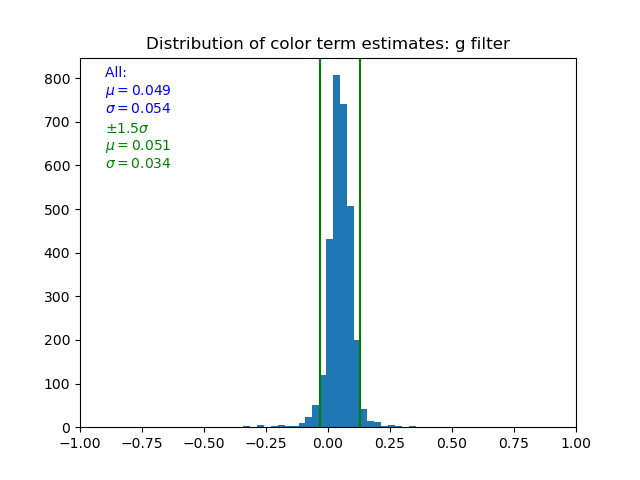

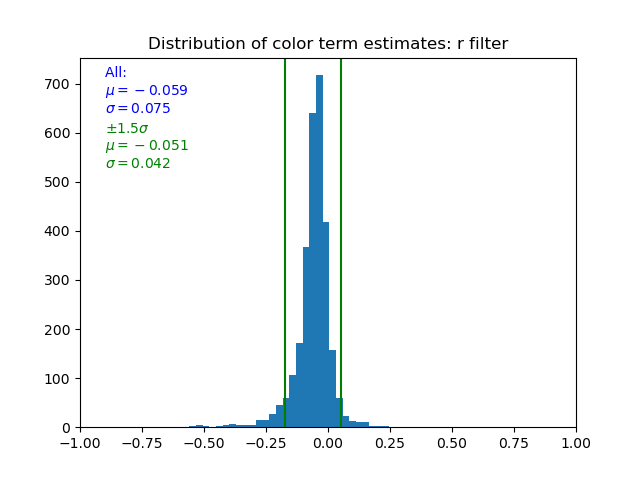

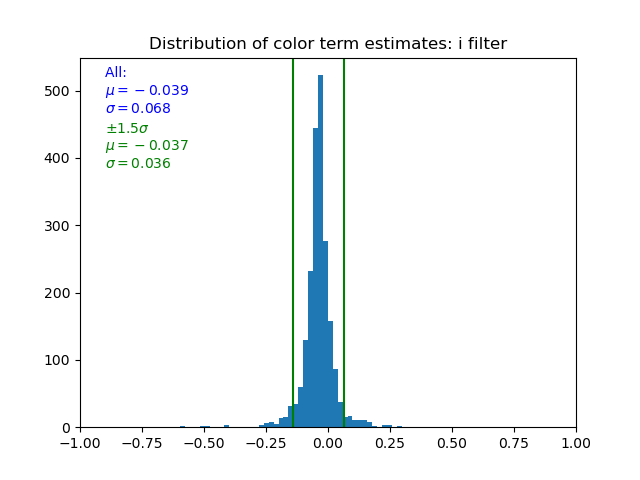

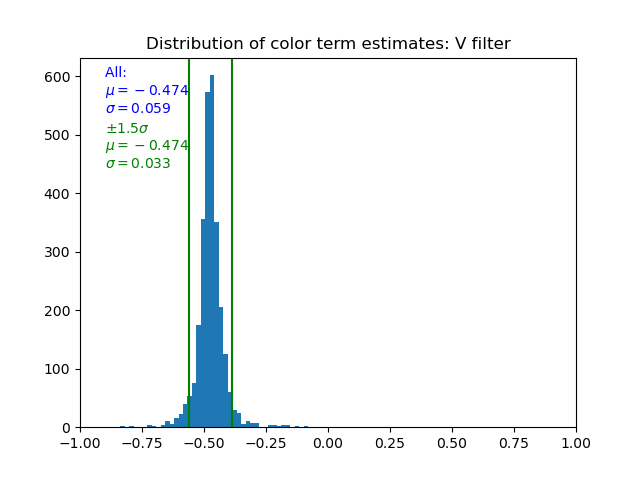

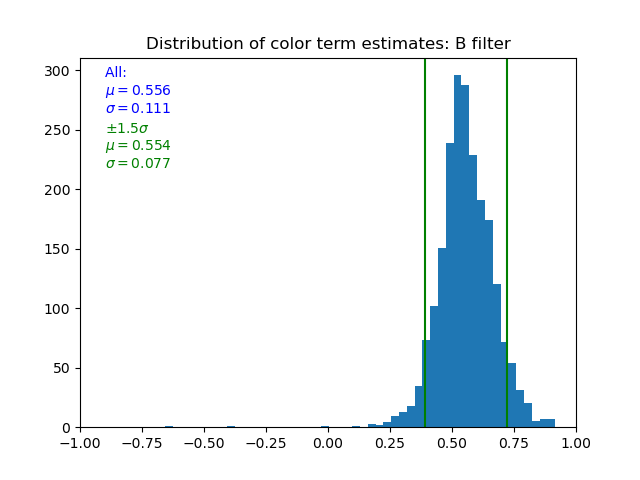

In [5]:
terms, errors = derive_color_terms(term_lists, term_error_lists, 1.5)